###**gamma_mod_ml**

This notebook extends findings from Jones et al., 2020, which showed that gamma frequency-tuned tACS, but not tDCS, increases gamma power during auditory click trains at the group level. There are two overarching goals:

1. **Characterize gamma-band steady-state evoked potentials (SSEPs) and extract features for machine learning.** Using spectral decomposition (specparam), bandpass filtering, time-domain analysis (response latency, amplitude dynamics), and cycle-by-cycle waveform analysis (bycycle), extract comprehensive features spanning frequency-domain, temporal, and waveform morphology characteristics. Engineer baseline-relative features to capture stimulation-induced change while controlling for inter-individual baseline differences, creating a 14-feature dataset for single-trial classification of stimulation conditions (tACS, tDCS, Sham).
2. **Classify stimulation conditions using data from a single channel (Cz).** Compare classification algorithms (random forest, gradient boosting, logistic regression, SVM) using a 70/30 random split (mixing epochs across all subjects in train and test sets) to account for individual differences in stimulation response. Optimize hyperparameters using 2-stage randomized search, identify optimal features through importance ranking, and validate model performance with permutation testing. Demonstrate that within-subject baseline-relative features enable single-trial classification (p < 0.01 vs. permuted models), with cycle-by-cycle waveform features (amplitude) dominating spectral power measures.

**Key scientific findings**:
- **Inter-individual variability in stimulation effects**: The permuted models achieving 0.633 accuracy (vs. 0.676 real) indicates that individual-specific neural signatures contribute substantially to classification performance, with condition-specific effects providing an additional but modest improvement. Stimulation responses may not generalize across subjects without personalized calibration.
- **Within-subject normalization of single trials**: Baseline-relative features control for between-subject differences in baseline variability while preserving single-trial resolution, enabling detection of subtle condition-specific patterns.
- **Importance of waveform dynamics**: Cycle-by-cycle amplitude dominates traditional spectral measures like peak power, suggesting that oscillatory waveform shape captures stimulation effects more sensitively than conventional spectral analysis at the single-trial level.
- **Non-linear decision boundaries**: Tree-based models outperform linear classifiers, indicating complex, non-linear relationships between EEG features and stimulation conditions.
- **Real-world deployment feasibility**: The within-subject calibration strategy mirrors realistic scenarios where baseline data are collected before classifying ongoing stimulation.

These results support the feasibility of real-time, personalized brain stimulation approaches where EEG signatures are used to adaptively monitor and optimize stimulation parameters on an individual basis.

Copyright (c) 2025  
EL Johnson, PhD

###Import modules:

In [1]:
import gdown
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install mne  # for custom modules
!pip install specparam
!pip install bycycle

# custom modules
from gamma_utils import load_eeg_files, compute_psd, fit_specparam, extract_ssep, \
  analyze_ssep, analyze_bycycle, create_paired_df
from plotting_utils import plot_psd, plot_specparam, plot_ssep, plot_ssep_temporal, \
  plot_bycycle
from ml_utils import compare_models, tune_gradient_boosting, rank_features, \
  test_feature_subsets, permutation_test

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 9.8 MB/s eta 0:00:00


###Download data from Google Drive:

In [2]:
# download
fid_tacs = '1jcZDPJbV7fPh85R3G9raQf2MpvHbfeWQ'
fid_tdcs = '1smAHUQBAF3WVL32t7jThWef03SLqKQQ1'
fid_sham = '13xCr3RUNQeoVr6SLdQw3N_gkTbXvm_rR'
fid_baseline = '1r_DP-FjMUWuRZ4dgWnIYKggcbupcLtEk'

url_tacs = f'https://drive.google.com/uc?id={fid_tacs}'
url_tdcs = f'https://drive.google.com/uc?id={fid_tdcs}'
url_sham = f'https://drive.google.com/uc?id={fid_sham}'
url_baseline = f'https://drive.google.com/uc?id={fid_baseline}'

gdown.download(url_tacs, 'tacs.zip', quiet = False)
gdown.download(url_tdcs, 'tdcs.zip', quiet = False)
gdown.download(url_sham, 'sham.zip', quiet = False)
gdown.download(url_baseline, 'baseline.zip', quiet = False)

# unzip
with zipfile.ZipFile('tacs.zip', 'r') as zip_ref:
  zip_ref.extractall()

with zipfile.ZipFile('tdcs.zip', 'r') as zip_ref:
  zip_ref.extractall()

with zipfile.ZipFile('sham.zip', 'r') as zip_ref:
  zip_ref.extractall()

with zipfile.ZipFile('baseline.zip', 'r') as zip_ref:
  zip_ref.extractall()

Downloading...
From (original): https://drive.google.com/uc?id=1jcZDPJbV7fPh85R3G9raQf2MpvHbfeWQ
From (redirected): https://drive.google.com/uc?id=1jcZDPJbV7fPh85R3G9raQf2MpvHbfeWQ&confirm=t&uuid=946b7888-0805-4eea-95b6-3aa2318b7a2d
To: /content/tacs.zip
100%|██████████| 328M/328M [00:03<00:00, 91.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1smAHUQBAF3WVL32t7jThWef03SLqKQQ1
From (redirected): https://drive.google.com/uc?id=1smAHUQBAF3WVL32t7jThWef03SLqKQQ1&confirm=t&uuid=ba228afc-3abc-48c4-825b-a2476b435202
To: /content/tdcs.zip
100%|██████████| 296M/296M [00:02<00:00, 148MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=13xCr3RUNQeoVr6SLdQw3N_gkTbXvm_rR
From (redirected): https://drive.google.com/uc?id=13xCr3RUNQeoVr6SLdQw3N_gkTbXvm_rR&confirm=t&uuid=e7e690c4-8ecd-49c7-a4ff-a248fb6a97b2
To: /content/sham.zip
100%|██████████| 330M/330M [00:01<00:00, 200MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1r_DP-FjMUWuRZ4dgWnIY

### Load the data

Each MATLAB input file contains one data structure per subject (`data_clean`), which is the output of FieldTrip's `ft_preprocessing`. Each structure contains the following variables of interest:
- `label` = channel names
- `time` = time vectors for each trial (sec)
- `trial` = EEG data (channels x timepoints per epoch)
- `fsample` = sampling rate (Hz)

The `load_eeg_files()` function converts these FieldTrip structures directly into MNE `Epochs` objects. Each output is a dictionary containing an MNE `Epochs` object (e.g., `KS`), preserving all channel info, trial data, and sampling parameters from the original MATLAB structure.

In [3]:
all_tacs = load_eeg_files(data_dir = '/content/tacs')
all_tdcs = load_eeg_files(data_dir = '/content/tdcs')
all_sham = load_eeg_files(data_dir = '/content/sham')
all_baseline = load_eeg_files(data_dir = '/content/baseline')


Found 15 files

Loading ZB...
Loading MC...
Loading OP...
Loading KS...
Loading GD...
Loading SM...
Loading NK...
Loading AR...
Loading AB...
Loading JK...
Loading ND...
Loading LS...
Loading LW...
Loading MT...
Loading LMH...

Found 15 files

Loading JM2...
Loading TF...
Loading RD...
Loading AK...
Loading LM...
Loading DT...
Loading IM...
Loading CF...
Loading PR...
Loading KM...
Loading DM...
Loading CH...
Loading JM...
Loading IW...
Loading MCB...

Found 15 files

Loading GSS...
Loading HC...
Loading SE...
Loading AH...
Loading CB...
Loading KR...
Loading AU...
Loading ZA...
Loading DG...
Loading POM...
Loading JB...
Loading ED...
Loading BP...
Loading AG...
Loading SP...

Found 45 files

Loading JM2...
Loading GSS...
Loading HC...
Loading ZB...
Loading MC...
Loading OP...
Loading KS...
Loading TF...
Loading RD...
Loading AK...
Loading LM...
Loading GD...
Loading SE...
Loading SM...
Loading DT...
Loading IM...
Loading CF...
Loading NK...
Loading AH...
Loading AR...
Loading CB...
L

In [4]:
all_tacs['KS']  # take a look

<EpochsArray | 197 events (all good), -0.5 – 1.75 s (baseline off), ~22.5 MiB, data loaded,
 '1': 197>

### Goal 1.1: Compute and visualize power spectral density (PSD)

**Analysis overview**: The `compute_psd()` function calculates power spectral density (1-55 Hz) using the multitaper method applied to the 500-ms stimulus window. PSD is computed for each trial at channel Cz, then averaged across trials within each subject. The `plot_psd()` function visualizes grand-averaged PSD (mean +/- SEM across subjects) for each treatment condition compared to its paired baseline.

**Key parameters**:
- Frequency range: 1-55 Hz captures both low-frequency and gamma-band activity
- Bandwidth: 2 Hz provides narrowband spectral smoothing
- Zero-padding: Extended to 2048 samples for 0.25 Hz frequency resolution
- Normalization: PSD in power/Hz, converted to dB for visualization

**Results**: The plots show clear 40 Hz peaks in all conditions, reflecting the 40 Hz steady-state evoked potential (SSEP) to the click train stimulus. Comparing post-treatment to baseline:
- tACS vs. baseline: The 40 Hz peak is enhanced in tACS relative to baseline, consistent with the published finding that 40 Hz tACS enhances gamma activity.
- tDCS vs. baseline: Near-identical profiles, consistent with the published finding that tDCS does not enhance gamma activity.
- Sham vs. baseline: Near-identical profiles, confirming stability of the SSEP in the control condition.

In [5]:
psd_tacs = compute_psd(all_tacs)
psd_tdcs = compute_psd(all_tdcs)
psd_sham = compute_psd(all_sham)
psd_baseline = compute_psd(all_baseline)

Computing PSD for ZB...
Computing PSD for MC...
Computing PSD for OP...
Computing PSD for KS...
Computing PSD for GD...
Computing PSD for SM...
Computing PSD for NK...
Computing PSD for AR...
Computing PSD for AB...
  Channel Cz not found, skipping AB
Computing PSD for JK...
Computing PSD for ND...
Computing PSD for LS...
Computing PSD for LW...
Computing PSD for MT...
Computing PSD for LMH...
Computing PSD for JM2...
Computing PSD for TF...
Computing PSD for RD...
Computing PSD for AK...
Computing PSD for LM...
Computing PSD for DT...
Computing PSD for IM...
Computing PSD for CF...
Computing PSD for PR...
Computing PSD for KM...
Computing PSD for DM...
Computing PSD for CH...
  Channel Cz not found, skipping CH
Computing PSD for JM...
Computing PSD for IW...
Computing PSD for MCB...
Computing PSD for GSS...
Computing PSD for HC...
Computing PSD for SE...
Computing PSD for AH...
Computing PSD for CB...
Computing PSD for KR...
Computing PSD for AU...
Computing PSD for ZA...
Computing PS

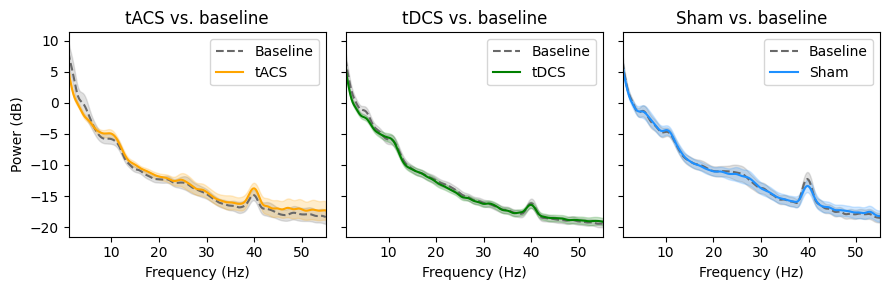

In [6]:
plot_psd(psd_baseline, psd_sham, psd_tacs, psd_tdcs)

### Goal 1.2: Parameterize power spectra and extract frequency-domain features

**Analysis overview**: The `fit_specparam()` function decomposes each trial's PSD into periodic (oscillatory) and aperiodic (1/f-like background) components using the specparam algorithm, and selects the the peak closest to 40 Hz. For each detected peak, the function extracts center frequency, power, bandwidth, and signal-to-noise ratio (SNR). Aperiodic parameters (offset and slope) characterize the 1/f-like background across the full 1-55 Hz range. The `plot_specparam()` function visualizes distributions of all six specparam features for each treatment condition compared to its paired baseline.

**Key parameters**:
- Frequency range: 1-55 Hz for aperiodic fitting, 30-50 Hz for peak detection
- Peak width limits: 1-10 Hz allows for natural variation in SSEP bandwidth
- Minimum peak height: 0.1 threshold for reliable peak detection
- Peak selection: Closest to 40 Hz within the 30-50 Hz gamma band

**Results**: The histograms show distributions of specparam features across all trials and subjects. Comparing post-treatment to baseline:
- **Peak frequency**: All conditions show tight distributions centered near 40 Hz, reflecting the stimulus-locked SSEP.
- **Peak power**: tACS shows increased peak power relative to baseline, consistent with enhanced gamma oscillations.
- **Peak bandwidth**: All conditions show majority narrow bandwidths, characteristic of stimulus-driven oscillations.
- **Peak SNR**: tACS shows decreased SNR relative to baseline, consistent with lower oscillatory activity relative to the aperiodic background.
- **Aperiodic offset**: Minimal differences across conditions, suggesting stable overall power.
- **Aperiodic slope**: All conditions show negative slopes characteristic of 1/f-like activity.

The observation of increased peak power and decreased SNR with tACS suggests that tACS enhances both oscillatory and aperiodic activity ~40 Hz, with greater enhancement of aperiodic activity.

In [7]:
specparam_tacs = fit_specparam(psd_tacs)
specparam_tdcs = fit_specparam(psd_tdcs)
specparam_sham = fit_specparam(psd_sham)
specparam_baseline = fit_specparam(psd_baseline)

Fitting ZB...
Fitting MC...
Fitting OP...
Fitting KS...
Fitting GD...
Fitting SM...
Fitting NK...
Fitting AR...
Fitting JK...
Fitting ND...
Fitting LS...
Fitting LW...
Fitting MT...
Fitting LMH...
Fitting JM2...
Fitting TF...
Fitting RD...
Fitting AK...
Fitting LM...
Fitting DT...
Fitting IM...
Fitting CF...
Fitting PR...
Fitting KM...
Fitting DM...
Fitting JM...
Fitting IW...
Fitting MCB...
Fitting GSS...
Fitting HC...
Fitting SE...
Fitting AH...
Fitting CB...
Fitting KR...
Fitting AU...
Fitting ZA...
Fitting DG...
Fitting JB...
Fitting ED...
Fitting BP...
Fitting AG...
Fitting JM2...
Fitting GSS...
Fitting HC...
Fitting ZB...
Fitting MC...
Fitting OP...
Fitting KS...
Fitting TF...
Fitting AK...
Fitting LM...
Fitting GD...
Fitting SE...
Fitting SM...
Fitting DT...
Fitting IM...
Fitting CF...
Fitting NK...
Fitting AH...
Fitting AR...
Fitting CB...
Fitting KR...
Fitting PR...
Fitting KM...
Fitting AU...
Fitting AB...
Fitting DM...
Fitting JK...
Fitting CH...
Fitting ND...
Fitting JM...


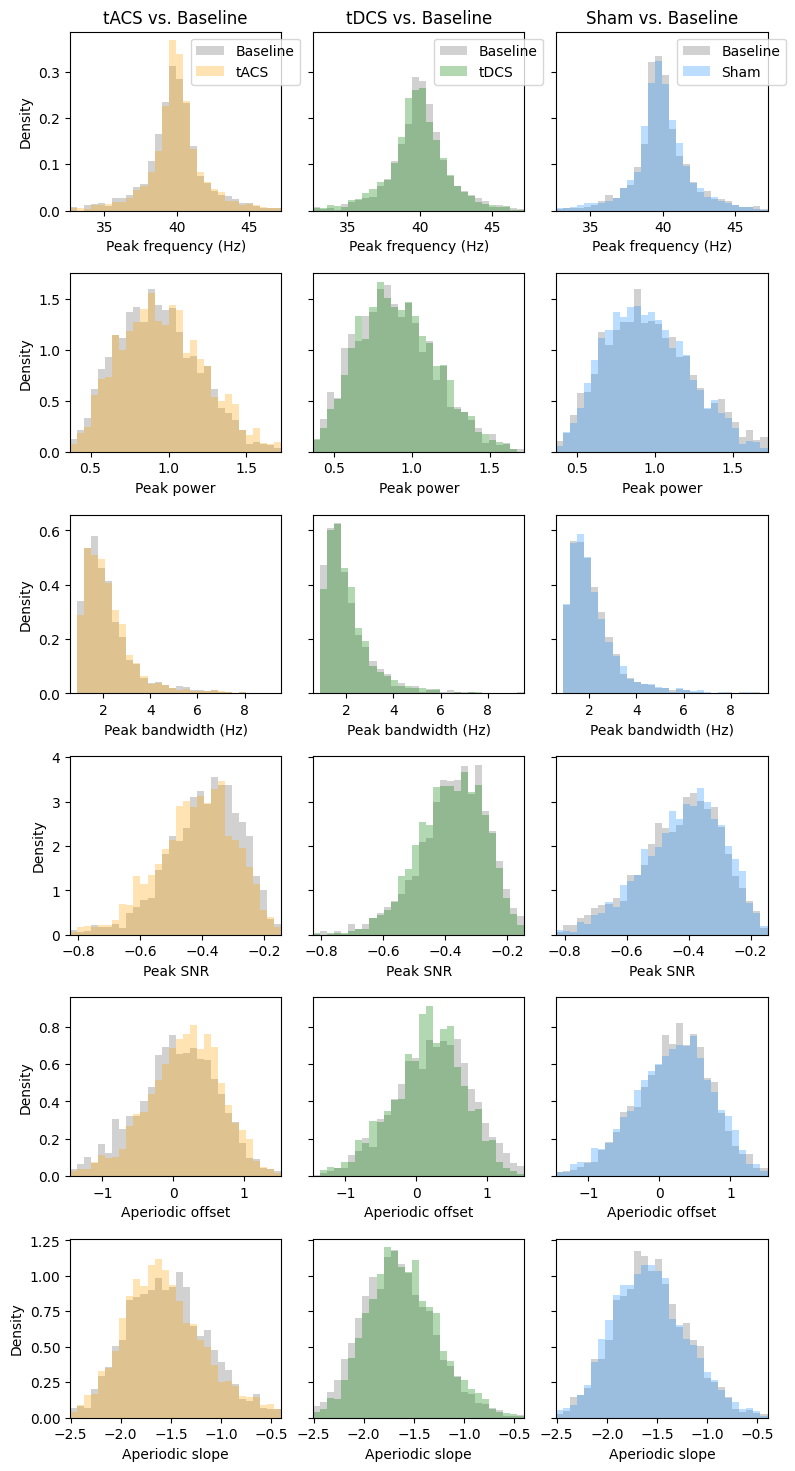

Specparam summary statistics

tACS vs. Baseline (N = 13 subjects):
Peak frequency (Hz): Baseline median = 39.856 | tACS median = 39.947
Peak power         : Baseline median =  0.915 | tACS median =  0.950
Peak bandwidth (Hz): Baseline median =  1.948 | tACS median =  1.980
Peak SNR           : Baseline median = -0.382 | tACS median = -0.412
Aperiodic offset   : Baseline median =  0.078 | tACS median =  0.190
Aperiodic slope    : Baseline median = -1.548 | tACS median = -1.597

tDCS vs. Baseline (N = 13 subjects):
Peak frequency (Hz): Baseline median = 40.013 | tDCS median = 39.871
Peak power         : Baseline median =  0.874 | tDCS median =  0.896
Peak bandwidth (Hz): Baseline median =  1.776 | tDCS median =  1.838
Peak SNR           : Baseline median = -0.363 | tDCS median = -0.375
Aperiodic offset   : Baseline median =  0.267 | tDCS median =  0.190
Aperiodic slope    : Baseline median = -1.677 | tDCS median = -1.630

Sham vs. Baseline (N = 13 subjects):
Peak frequency (Hz): Baseline

In [8]:
plot_specparam(specparam_baseline, specparam_sham, specparam_tacs, specparam_tdcs)

### Goal 1.3: Compute and visualize bandpass-filtered SSEP signals

**Analysis overview**: The `extract_ssep()` function isolates trial-specific gamma oscillations by applying a bandpass filter centered on each trial's peak frequency and bandwidth from specparam. For each trial, a second-order Butterworth filter is applied to the raw signal at channel Cz. The `plot_ssep()` function visualizes example filtered SSEP traces from one trial per condition compared to baseline.

**Key parameters**:
- Filter range: Defined by peak center frequency and bandwidth from specparam
- Filter design: Second-order Butterworth bandpass filter for stable frequency response
- Zero-phase filtering: Forward-backward filtering preserves temporal features

**Results**: The example traces illustrate the filtered ~40 Hz oscillations over the 500-ms stimulus window. The plots show sustained oscillatory activity across all conditions, with marked trial-to-trial variability.

In [9]:
ssep_tacs = extract_ssep(all_tacs, specparam_tacs)
ssep_tdcs = extract_ssep(all_tdcs, specparam_tdcs)
ssep_sham = extract_ssep(all_sham, specparam_sham)
ssep_baseline = extract_ssep(all_baseline, specparam_baseline)

Extracting SSEPs for ZB...
Extracting SSEPs for MC...
Extracting SSEPs for OP...
Extracting SSEPs for KS...
Extracting SSEPs for GD...
Extracting SSEPs for SM...
Extracting SSEPs for NK...
Extracting SSEPs for AR...
Extracting SSEPs for AB...
  Channel Cz not found, skipping AB
Extracting SSEPs for JK...
Extracting SSEPs for ND...
Extracting SSEPs for LS...
Extracting SSEPs for LW...
Extracting SSEPs for MT...
Extracting SSEPs for LMH...
Extracting SSEPs for JM2...
Extracting SSEPs for TF...
Extracting SSEPs for RD...
Extracting SSEPs for AK...
Extracting SSEPs for LM...
Extracting SSEPs for DT...
Extracting SSEPs for IM...
Extracting SSEPs for CF...
Extracting SSEPs for PR...
Extracting SSEPs for KM...
Extracting SSEPs for DM...
Extracting SSEPs for CH...
  Channel Cz not found, skipping CH
Extracting SSEPs for JM...
Extracting SSEPs for IW...
Extracting SSEPs for MCB...
Extracting SSEPs for GSS...
Extracting SSEPs for HC...
Extracting SSEPs for SE...
Extracting SSEPs for AH...
Extrac

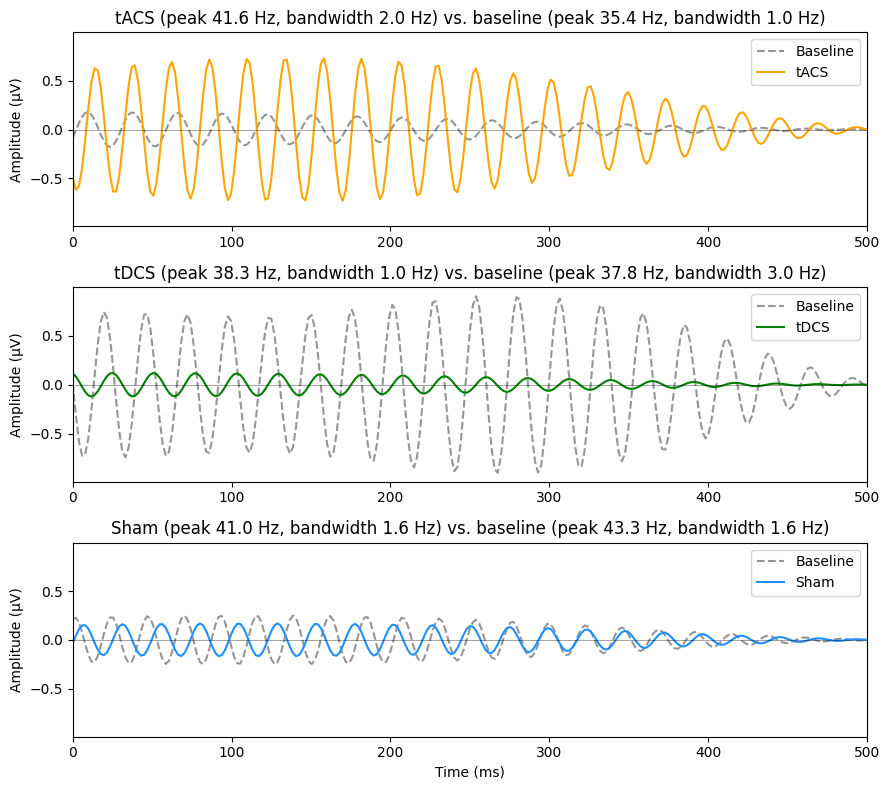

In [10]:
plot_ssep(ssep_baseline, ssep_sham, ssep_tacs, ssep_tdcs)

### Goal 1.4: Extract time-domain features from SSEP signals

**Analysis overview**: The `analyze_ssep()` function extracts three time-domain features from the filtered SSEP signals. Response latency measures the onset time of the SSEP using Hilbert envelope thresholding. Amplitude slope quantifies the rate of amplitude change by fitting a linear trend to the smoothed envelope. Autocorrelation at 1-cycle lag assesses oscillation consistency by correlating the signal with itself shifted by one period. The `plot_ssep_temporal()` function visualizes distributions of all three temporal features for each treatment condition compared to its paired baseline.

**Key parameters**:
- Response latency: 50% of maximum envelope threshold with 50-ms smoothing window
- Amplitude slope: Linear fit to Hilbert envelope over time
- Autocorrelation: Pearson correlation at 1-cycle lag

**Results**: The histograms show distributions of temporal features across all trials and subjects. Comparing post-treatment to baseline:
- **Response latency**: All conditions show rapid onset, reflecting the stimulus-locked nature of SSEPs, with tACS and tDCS potentially slowing the onset.
- **Amplitude slope**: All conditions show slightly negative slopes, indicating gradual amplitude decay over the stimulus window, consistent with adaptation.
- **Autocorrelation**: All conditions show high autocorrelation, reflecting sustained oscillatory consistency throughout the stimulus window.

In [11]:
temporal_tacs = analyze_ssep(ssep_tacs)
temporal_tdcs = analyze_ssep(ssep_tdcs)
temporal_sham = analyze_ssep(ssep_sham)
temporal_baseline = analyze_ssep(ssep_baseline)

Computing temporal features for ZB...
Computing temporal features for MC...
Computing temporal features for OP...
Computing temporal features for KS...
Computing temporal features for GD...
Computing temporal features for SM...
Computing temporal features for NK...
Computing temporal features for AR...
Computing temporal features for JK...
Computing temporal features for ND...
Computing temporal features for LS...
Computing temporal features for LW...
Computing temporal features for MT...
Computing temporal features for LMH...
Computing temporal features for JM2...
Computing temporal features for TF...
Computing temporal features for RD...
Computing temporal features for AK...
Computing temporal features for LM...
Computing temporal features for DT...
Computing temporal features for IM...
Computing temporal features for CF...
Computing temporal features for PR...
Computing temporal features for KM...
Computing temporal features for DM...
Computing temporal features for JM...
Computing 

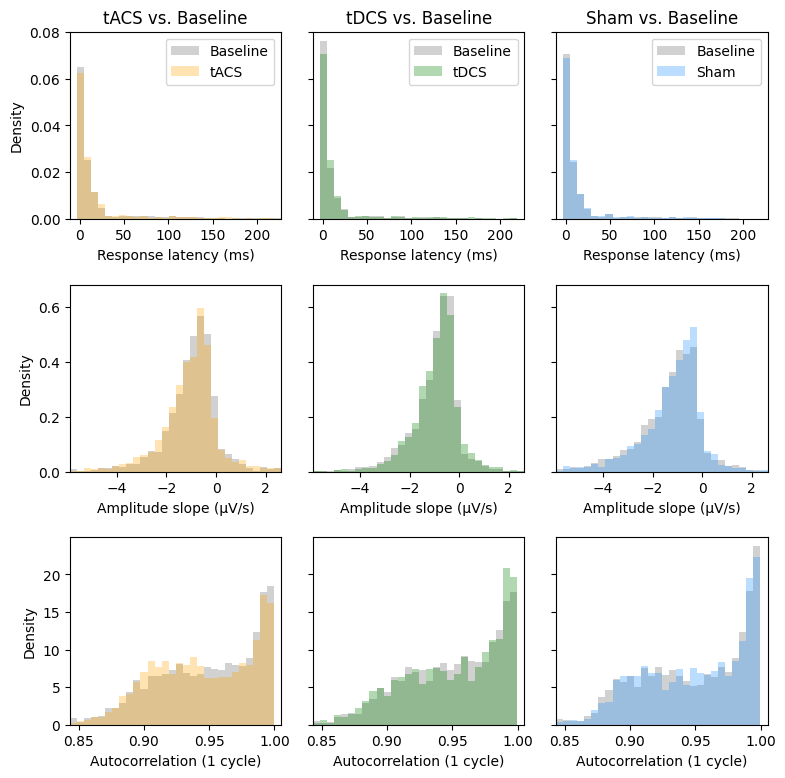

SSEP temporal features summary statistics

tACS vs. Baseline (N = 13 subjects):
Response latency (ms)    : Baseline median =  3.906 | tACS median =  5.859
Amplitude slope (μV/s)   : Baseline median = -0.833 | tACS median = -0.916
Autocorrelation (1 cycle): Baseline median =  0.953 | tACS median =  0.946

tDCS vs. Baseline (N = 13 subjects):
Response latency (ms)    : Baseline median =  1.953 | tDCS median =  3.906
Amplitude slope (μV/s)   : Baseline median = -0.779 | tDCS median = -0.782
Autocorrelation (1 cycle): Baseline median =  0.956 | tDCS median =  0.958

Sham vs. Baseline (N = 13 subjects):
Response latency (ms)    : Baseline median =  3.906 | Sham median =  3.906
Amplitude slope (μV/s)   : Baseline median = -1.074 | Sham median = -0.994
Autocorrelation (1 cycle): Baseline median =  0.954 | Sham median =  0.954


In [12]:
plot_ssep_temporal(temporal_baseline, temporal_sham, temporal_tacs, temporal_tdcs)

### Goal 1.5: Extract cycle-by-cycle waveform features

**Analysis overview**: The `analyze_bycycle()` function computes cycle-by-cycle features from the raw signal at channel Cz using the bycycle algorithm. For each trial, individual oscillation cycles are detected and characterized by amplitude, period, rise/decay times, waveform symmetry, peak/trough sharpness, and burst rate. Burst detection uses relaxed thresholds optimized for stimulus-driven 40 Hz SSEPs. The `plot_bycycle()` function visualizes distributions of all eight bycycle features for each treatment condition compared to its paired baseline.

**Key parameters**:
- Frequency range: 30-50 Hz for cycle detection
- Waveform features: Computed from peak-trough dynamics within each cycle
- Burst thresholds: Amplitude fraction = 0.2, consistency = 0.6, monotonicity = 0.6, minimum cycles = 2

**Results**: The histograms show distributions of cycle-by-cycle features across all trials and subjects. Comparing post-treatment to baseline:
- **Amplitude**: tACS shows increased amplitude relative to baseline, consistent with enhanced gamma oscillations.
- **Period**: All conditions show periods centered around 25 ms, corresponding to the 40 Hz stimulus frequency.
- **Rise time**: All conditions show rise times centered near 12-13 ms (half period).
- **Decay time**: All conditions show decay times centered near 12-13 ms (half period).
- **Rise-decay symmetry**: All conditions show symmetry near 0.5, indicating balanced waveform shape.
- **Peak voltage**: Minimal differences across conditions.
- **Trough voltage**: tACS may lower the trough relative to baseline, suggesting sharpening.
- **Burst rate**: All conditions show low burst rates. This likely reflects the steady-state nature of SSEPs, which are continuous stimulus-driven oscillations rather than intermittent bursts emerging from background activity.


In [13]:
bycycle_tacs = analyze_bycycle(all_tacs, specparam_tacs)
bycycle_tdcs = analyze_bycycle(all_tdcs, specparam_tdcs)
bycycle_sham = analyze_bycycle(all_sham, specparam_sham)
bycycle_baseline = analyze_bycycle(all_baseline, specparam_baseline)

Computing bycycle features for ZB...
Computing bycycle features for MC...
Computing bycycle features for OP...
Computing bycycle features for KS...
Computing bycycle features for GD...
Computing bycycle features for SM...
Computing bycycle features for NK...
Computing bycycle features for AR...
Computing bycycle features for AB...
  Channel Cz not found, skipping AB
Computing bycycle features for JK...
Computing bycycle features for ND...
Computing bycycle features for LS...
Computing bycycle features for LW...
Computing bycycle features for MT...
Computing bycycle features for LMH...
Computing bycycle features for JM2...
Computing bycycle features for TF...
Computing bycycle features for RD...
Computing bycycle features for AK...
Computing bycycle features for LM...
Computing bycycle features for DT...
Computing bycycle features for IM...
Computing bycycle features for CF...
Computing bycycle features for PR...
Computing bycycle features for KM...
Computing bycycle features for DM...


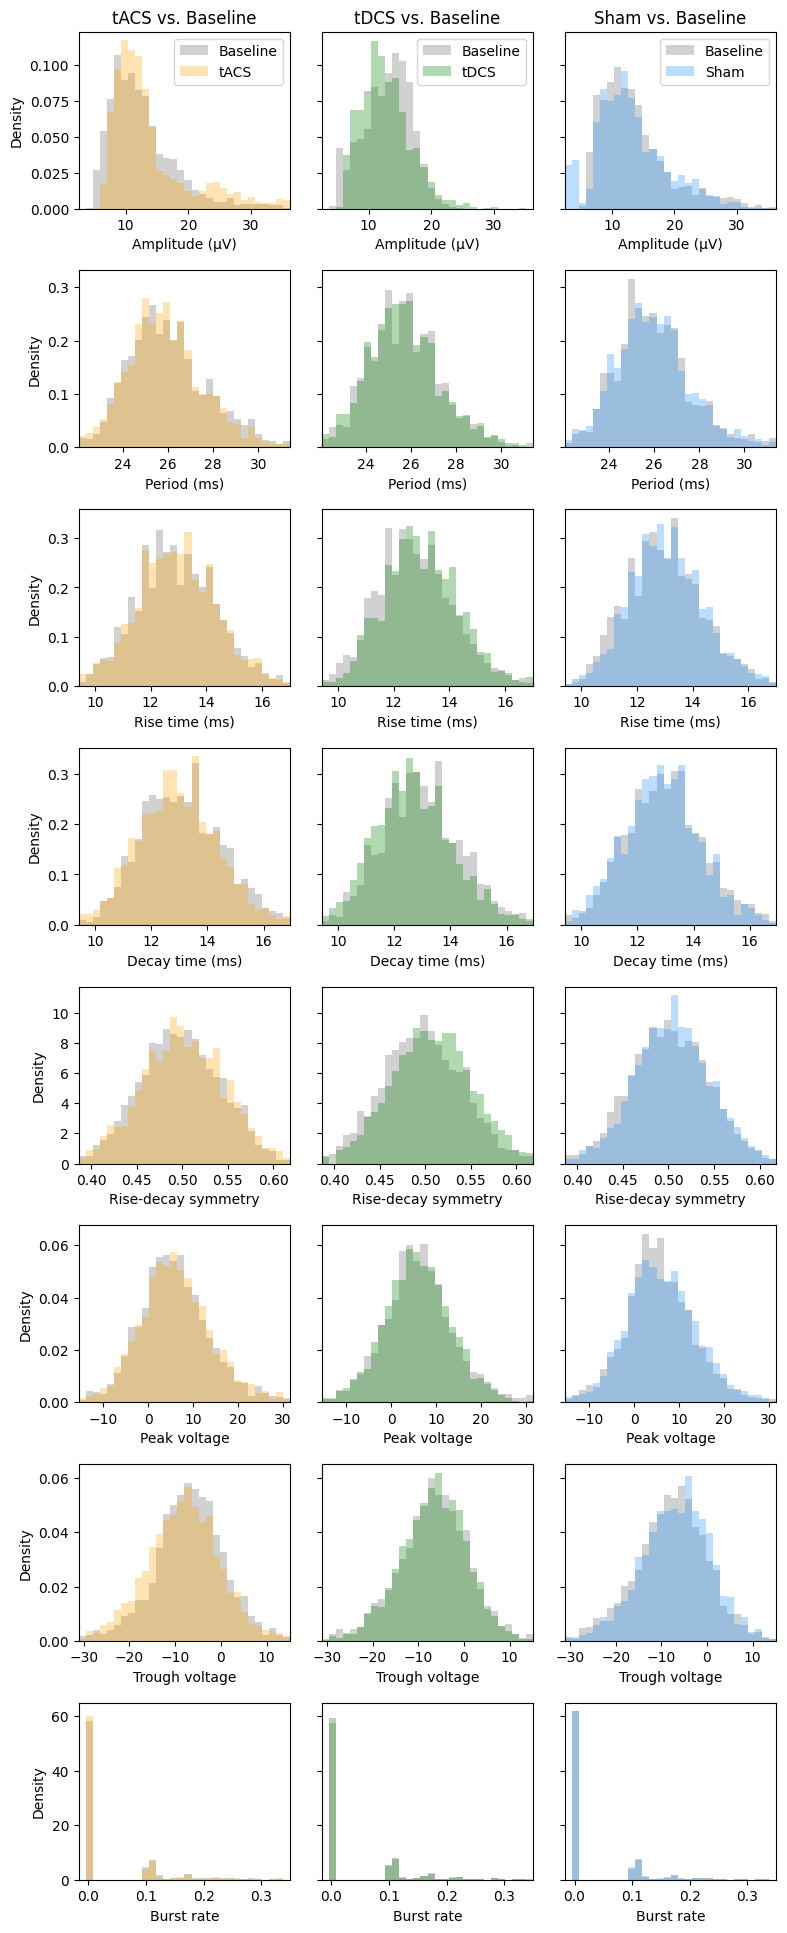

Bycycle features summary statistics

tACS vs. Baseline (N = 13 subjects):
Amplitude (μV)     : Baseline median = 11.501 | tACS median = 11.984
Period (ms)        : Baseline median = 25.825 | tACS median = 25.716
Rise time (ms)     : Baseline median = 12.850 | tACS median = 12.912
Decay time (ms)    : Baseline median = 13.021 | tACS median = 12.912
Rise-decay symmetry: Baseline median =  0.497 | tACS median =  0.500
Peak voltage       : Baseline median =  5.415 | tACS median =  5.740
Trough voltage     : Baseline median = -6.619 | tACS median = -8.052
Burst rate         : Baseline median =  0.000 | tACS median =  0.000

tDCS vs. Baseline (N = 13 subjects):
Amplitude (μV)     : Baseline median = 13.345 | tDCS median = 12.203
Period (ms)        : Baseline median = 25.608 | tDCS median = 25.499
Rise time (ms)     : Baseline median = 12.695 | tDCS median = 12.912
Decay time (ms)    : Baseline median = 12.891 | tDCS median = 12.638
Rise-decay symmetry: Baseline median =  0.497 | tDCS median 

In [14]:
plot_bycycle(bycycle_baseline, bycycle_sham, bycycle_tacs, bycycle_tdcs)

### Goal 1.6: Engineer features and reduce dimensionality

**Analysis overview**: Correlated features were identified and redundant variables removed to optimize the feature space for ML. The `rise_time` and `decay_time` features showed high correlation (r = 0.77) with `rise_decay_symmetry` and minimal discriminative value across conditions. These were dropped in favor of the symmetry metric. The `peak_voltage` feature was dropped due to minimal differences across conditions and redundancy with the `trough_voltage` feature (r = 0.78). To leverage the known effect of tACS on change from baseline and control for individual differences, baseline-relative features were computed for all stimulation trials. Each stimulation trial's features were then expressed as change from that subject's baseline, allowing single-trial classification while directly modeling the physiological effect of interest.

**Key parameters**:
- Dropped features: `rise_time`, `decay_time` (high correlation with `rise_decay_symmetry`, minimal between-condition variance); `peak_voltage` (redundant with `trough_voltage`, minimal condition differences)
- Baseline reference: Subject-specific median of each feature across baseline trials
- Feature transformation: Change from baseline (stim_trial - baseline_median) for all 14 features
- Final feature count: 14 baseline-relative features

**Results**: The baseline-relative feature engineering approach controls for between-subject variability while preserving single-trial resolution for classification. This transformation models the known physiological effect (tACS-induced change from baseline) and mirrors realistic deployment scenarios where a baseline calibration period precedes stimulation. The resulting features span spectral (`peak_frequency`, `peak_power`, `peak_bandwidth`, `peak_snr`, `aperiodic_offset`, `aperiodic_slope`), temporal (`response_latency`, `amplitude_slope`, `autocorr_1cycle`), and waveform morphology (`amplitude`, `period`, `rise_decay_symmetry`, `trough_voltage`, `burst_rate`) domains, expressed as changes that should differentiate tACS from tDCS and sham conditions. Dataset includes 6923 stimulation trials (tACS: 2332, tDCS: 2183, Sham: 2408) across 39 subjects, maintaining an appropriate features-to-samples ratio (14 features / 6923 trials = 0.002).

In [15]:
# create df of all conditions and paired baselines
df = create_paired_df(
    specparam_baseline, specparam_sham, specparam_tacs, specparam_tdcs,
    temporal_baseline, temporal_sham, temporal_tacs, temporal_tdcs,
    bycycle_baseline, bycycle_sham, bycycle_tacs, bycycle_tdcs
)

print(f'Total: {len(df)} trials, {len(df["sid"].unique())} subjects')
print(f'  Baseline: {(df.condition == "Baseline").sum()} trials')
print(f'  tACS/tDCS/Sham: {len(df) - (df.condition == "Baseline").sum()} trials')
print(f'\nNumber of features: {len(df.columns[4:])}')
print(f'\n{df.head()}')

Total: 13798 trials, 39 subjects
  Baseline: 6875 trials
  tACS/tDCS/Sham: 6923 trials

Number of features: 17

  sid  tid condition group  peak_frequency  peak_power  peak_bandwidth  \
0  ZB    0  Baseline  tACS       40.191992    0.557502        1.044872   
1  ZB    1  Baseline  tACS       40.869172    1.360604        1.514211   
2  ZB    2  Baseline  tACS       38.517273    0.901494        1.540602   
3  ZB    3  Baseline  tACS       39.678298    0.807949        7.856509   
4  ZB    4  Baseline  tACS       36.144241    0.941411        5.033196   

   peak_snr  aperiodic_offset  aperiodic_slope  ...  amplitude_slope  \
0 -0.257719          1.221178        -2.108967  ...        -0.268259   
1 -0.513331          0.753968        -2.114434  ...        -0.203453   
2 -0.360413          0.308013        -1.771910  ...        -0.724142   
3 -0.301851          0.669604        -2.092274  ...        -0.151276   
4 -0.344309          0.215134        -1.891441  ...         0.736306   

   autocor

In [16]:
# correlate all features to identify redundant variables
tmp = df.drop(columns = ['sid', 'tid', 'condition', 'group'])
tmp.corr()

,peak_frequency,peak_power,peak_bandwidth,peak_snr,aperiodic_offset,aperiodic_slope,response_latency,amplitude_slope,autocorr_1cycle,amplitude,period,rise_time,decay_time,rise_decay_symmetry,peak_voltage,trough_voltage,burst_rate
peak_frequency,1.000000,-0.017859,0.036853,0.054504,0.011846,-0.003381,0.019121,0.041053,-0.096370,0.008058,-0.128287,-0.077052,-0.078268,0.000406,0.003833,-0.001757,-0.007740
peak_power,-0.017859,1.000000,0.081709,-0.846570,0.007269,-0.067021,0.094442,-0.284489,-0.076266,0.044066,-0.105691,-0.039562,-0.088107,0.029899,0.012251,-0.015810,0.064318
peak_bandwidth,0.036853,0.081709,1.000000,-0.068847,-0.052861,0.046855,0.524609,0.136598,-0.251503,0.018761,-0.041345,-0.007518,-0.042327,0.021690,0.000600,-0.012788,0.029643
peak_snr,0.054504,-0.846570,-0.068847,1.000000,-0.024970,-0.194317,-0.076342,0.473393,0.056318,-0.453046,0.100503,0.051421,0.070151,-0.011434,-0.134604,0.164845,-0.121944
aperiodic_offset,0.011846,0.007269,-0.052861,-0.024970,1.000000,-0.835941,-0.028761,-0.009587,0.011231,0.054971,0.116162,0.083194,0.057611,0.022741,0.007441,-0.023858,-0.180013
aperiodic_slope,-0.003381,-0.067021,0.046855,-0.194317,-0.835941,1.000000,0.024193,-0.168792,-0.004133,0.366153,-0.106208,-0.092438,-0.036503,-0.040891,0.112344,-0.134550,0.212728
response_latency,0.019121,0.094442,0.524609,-0.076342,-0.028761,0.024193,1.000000,0.451386,-0.130892,0.003007,-0.010326,0.004828,-0.017195,0.011818,-0.004816,-0.006711,0.019435
amplitude_slope,0.041053,-0.284489,0.136598,0.473393,-0.009587,-0.168792,0.451386,1.000000,-0.046643,-0.374644,0.057547,0.029473,0.040138,-0.011096,-0.128629,0.121566,-0.073060
autocorr_1cycle,-0.096370,-0.076266,-0.251503,0.056318,0.011231,-0.004133,-0.130892,-0.046643,1.000000,0.026782,0.011926,0.016530,-0.001976,0.015181,0.008405,-0.012845,-0.003236
amplitude,0.008058,0.044066,0.018761,-0.453046,0.054971,0.366153,0.003007,-0.374644,0.026782,1.000000,0.052211,0.007597,0.055325,-0.032573,0.349315,-0.318343,0.271444


In [17]:
# drop redundant variables
df = df.drop(columns = ['rise_time', 'decay_time', 'peak_voltage'])
features = df.columns[4:]
print(f'Final number of features: {len(features)}')

Final number of features: 14


In [18]:
# compute baseline reference per subject
baseline_refs = df[df['condition'] == 'Baseline'].groupby('sid')[features].median()

# compute change from baseline for stimulation trials
stim_trials = df[df['condition'] != 'Baseline'].copy()
for sid in stim_trials['sid'].unique():
    mask = stim_trials['sid'] == sid
    stim_trials.loc[mask, features] = (
        stim_trials.loc[mask, features].values - baseline_refs.loc[sid].values
    )

stim_trials = stim_trials.drop(columns = 'condition')  # now redundant with group

print(f'Total: {len(stim_trials)} trials, {len(stim_trials["sid"].unique())} subjects')
print(f'  tACS: {(stim_trials.group == "tACS").sum()} trials')
print(f'  tDCS: {(stim_trials.group == "tDCS").sum()} trials')
print(f'  Sham: {(stim_trials.group == "Sham").sum()} trials')
print(f'\n{stim_trials.head()}')

Total: 6923 trials, 39 subjects
  tACS: 2332 trials
  tDCS: 2183 trials
  Sham: 2408 trials

    sid  tid group  peak_frequency  peak_power  peak_bandwidth  peak_snr  \
188  ZB    0  tACS        2.077226    0.120128        8.117991 -0.044719   
189  ZB    1  tACS        0.404155   -0.288221       -0.806609  0.113775   
190  ZB    2  tACS        2.576248    0.049033       -0.445004  0.011673   
191  ZB    3  tACS        2.980534   -0.125272        2.923744  0.063573   
192  ZB    4  tACS       -6.976054   -0.160412       -0.670501  0.025478   

     aperiodic_offset  aperiodic_slope  response_latency  amplitude_slope  \
188         -0.980445         0.619225         23.437500         0.088509   
189         -0.027641         0.035010         -1.953125         0.287341   
190          0.536902        -0.445565         -3.906250        -0.173541   
191         -1.136606         0.656959         15.625000        -0.626078   
192          0.466569        -0.187587         -1.953125        -

### Goal 2.1: Compare models to classify stimulation condition

**Analysis overview**: Four ML models were compared to classify stimulation conditions (tACS, tDCS, Sham) using single-trial baseline-relative features with a 70/30 train/test split. This within-subject calibration strategy mirrors realistic deployment scenarios where baseline trials are collected before stimulation. A train/test split approach was used rather than leave-one-subject-out cross-validation to account for individual differences in stimulation response.

**Models tested**:
-  Random forest (200 trees, `max_depth` = 15, balanced class weights)
- Gradient boosting (200 estimators, `max_depth` = 6, `learning_rate` = 0.1)
- Logistic regression (L2 regularization, `C` = 1.0, balanced class weights, `StandardScaler`)
- SVM (RBF kernel, `C` = 1.0, balanced class weights, `StandardScaler`)

**Results**: Gradient boosting achieved the highest performance (balanced accuracy = 0.667), followed by random forest (0.619). Tree-based methods outperformed linear models (logistic regression: 0.439, SVM: 0.548).

**Interpretation**: The 2x improvement over chance (0.333) for 3-class classification demonstrates that within-subject baseline-relative features enable condition discrimination despite high trial-to-trial variability in EEG data. Superior performance of tree-based methods over linear models suggests complex, non-linear decision boundaries between conditions.

In [19]:
results = compare_models(stim_trials, features)

Train set: 4846 trials
Test set: 2077 trials

Testing Random Forest...
Accuracy:          0.619
Balanced accuracy: 0.619
F1 (weighted):     0.616
F1 (macro):        0.616

Confusion matrix:
              Predicted
              Sham     tACS     tDCS    
Actual Sham   380      206      136     
       tACS   95       523      82      
       tDCS   104      169      382     

Classification report:
              precision    recall  f1-score   support

        Sham       0.66      0.53      0.58       722
        tACS       0.58      0.75      0.65       700
        tDCS       0.64      0.58      0.61       655

    accuracy                           0.62      2077
   macro avg       0.63      0.62      0.62      2077
weighted avg       0.63      0.62      0.62      2077

Testing Gradient Boosting...
Accuracy:          0.667
Balanced accuracy: 0.667
F1 (weighted):     0.666
F1 (macro):        0.666

Confusion matrix:
              Predicted
              Sham     tACS     tDCS    
Actu

### Goal 2.2: Optimize hyperparameters

**Analysis overview**: Gradient boosting hyperparameters were optimized using a 2-stage randomized search strategy. Stage 1 performed a coarse search across wide parameter ranges to identify promising regions of the hyperparameter space. Stage 2 performed a fine search with narrowed ranges centered on the best Stage 1 parameters. This approach balances computational efficiency with thorough exploration.

**Key parameters**:
- Stage 1 (coarse search): 30 iterations, wide ranges
  - `n_estimators` = 100-500
  - `max_depth` = 3-10
  - `learning_rate` = 0.01-0.30
  - `min_samples_split` = 10-50
  - `min_samples_leaf` = 5-30
  - `subsample` = 0.6-1.0
  - `max_features` = ['sqrt', 'log2', None]
- Stage 2 (fine search): 20 iterations, narrow ranges (+/- 50 `n_estimators`, +/- 1 `max_depth`, +/- 0.05 `learning_rate`, etc.)
- Cross-validation: 5-fold stratified CV on training set
- Scoring metric: Balanced accuracy

**Results**: The 2-stage search identified optimal hyperparameters: `n_estimators` = 339, `max_depth` = 7, `learning_rate` = 0.344, `min_samples_split` = 15, `min_samples_leaf` = 9, `subsample` = 0.912, `max_features` = None. Test set performance reached 0.686 balanced accuracy, a +0.019 improvement over defaults.

**Interpretation**: The slight gain suggests the default gradient boosting parameters were well-suited to this dataset, though optimization still provided improvement. The optimized model showed balanced class performance (Sham: 0.68, tACS: 0.73, tDCS: 0.65 recall), indicating no systematic bias toward any condition.

In [20]:
best_model, search_results = tune_gradient_boosting(stim_trials, features)

Train set: 4846 trials
Test set: 2077 trials

Stage 1: Coarse search (30 iterations, wide ranges)
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best CV score: 0.650

Best parameters from stage 1:
  classifier__learning_rate: 0.2944497234279625
  classifier__max_depth: 8
  classifier__max_features: None
  classifier__min_samples_leaf: 9
  classifier__min_samples_split: 15
  classifier__n_estimators: 343
  classifier__subsample: 0.8150842276932748


Stage 2: Fine search (20 iterations, narrow ranges)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best CV score: 0.658

Final best parameters:
  classifier__learning_rate: 0.3439520298932732
  classifier__max_depth: 7
  classifier__max_features: None
  classifier__min_samples_leaf: 9
  classifier__min_samples_split: 15
  classifier__n_estimators: 339
  classifier__subsample: 0.9116712233706901

Test set performance:
Accuracy:          0.687
Balanced accuracy: 0.686
F1 (macro):        0.686

Confusion matrix:


### Goal 2.3: Identify optimal features

**Analysis overview**: Feature importance was quantified using the trained gradient boosting model's built-in feature importance scores. All 14 features were ranked, and cumulative importance was calculated to identify thresholds. Performance was evaluated across different feature subset sizes using the optimized hyperparameters to determine the optimal balance between model complexity and predictive performance.

**Key parameters**:
- Model: Gradient boosting with optimized hyperparameters
- Feature subsets tested: Top 5-14 features
- Importance metric: Gradient boosting feature importances
- Evaluation: Balanced accuracy on held-out test set

**Results**: Feature importance analysis revealed `amplitude` as the dominant discriminative feature, followed by `burst_rate` and `autocorr_1cycle`. Performance testing across feature subsets identified the 14-feature set as optimal, achieving 0.676 balanced accuracy. (Note: the 0.01 difference from hyperparameter fine-tuning is expected due to model retraining.) The optimal model maintained balanced 3-class performance (Sham: 0.72, tACS: 0.72, tDCS: 0.65 recall).

**Interpretation**: `peak_power` was identified as the least important feature, demonstrating that `amplitude` captures gamma enhancement more directly.

Feature importance ranking:
Rank   Feature                   Importance   % Total    Cumulative %   
1      amplitude                 0.2487       24.87      24.87          
2      burst_rate                0.1072       10.72      35.58          
3      autocorr_1cycle           0.0750       7.50       43.08          
4      aperiodic_offset          0.0643       6.43       49.51          
5      peak_frequency            0.0627       6.27       55.78          
6      trough_voltage            0.0605       6.05       61.84          
7      amplitude_slope           0.0556       5.56       67.40          
8      response_latency          0.0547       5.47       72.87          
9      rise_decay_symmetry       0.0496       4.96       77.82          
10     period                    0.0492       4.92       82.74          
11     peak_snr                  0.0464       4.64       87.39          
12     peak_bandwidth            0.0445       4.45       91.84          
13     aperiodic_slope 

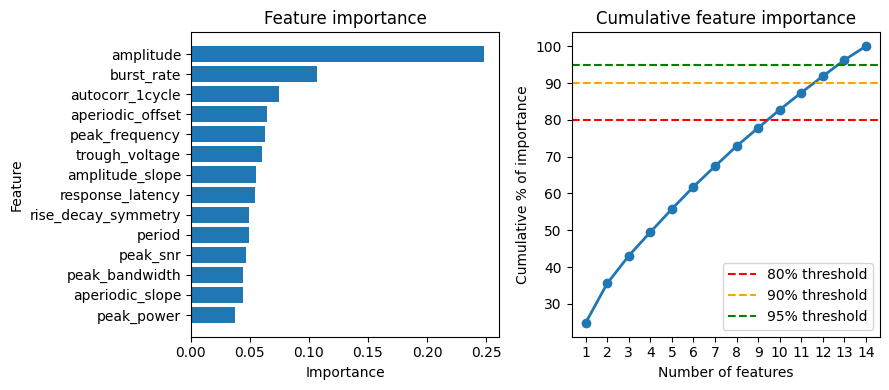

In [21]:
# rank features by importance
importances_df = rank_features(stim_trials, features, best_model)

Train set: 4846 trials
Test set: 2077 trials

Testing top 5 features...
  Accuracy: 0.595, Balanced accuracy: 0.594, F1 (macro): 0.594
  Features: amplitude, burst_rate, autocorr_1cycle, aperiodic_offset, peak_frequency

Testing top 6 features...
  Accuracy: 0.613, Balanced accuracy: 0.612, F1 (macro): 0.612
  Features: amplitude, burst_rate, autocorr_1cycle, aperiodic_offset, peak_frequency, trough_voltage

Testing top 7 features...
  Accuracy: 0.610, Balanced accuracy: 0.609, F1 (macro): 0.609
  Features: amplitude, burst_rate, autocorr_1cycle, aperiodic_offset, peak_frequency, trough_voltage, amplitude_slope

Testing top 8 features...
  Accuracy: 0.648, Balanced accuracy: 0.648, F1 (macro): 0.648
  Features: amplitude, burst_rate, autocorr_1cycle, aperiodic_offset, peak_frequency, trough_voltage, amplitude_slope, response_latency

Testing top 9 features...
  Accuracy: 0.652, Balanced accuracy: 0.651, F1 (macro): 0.651
  Features: amplitude, burst_rate, autocorr_1cycle, aperiodic_off

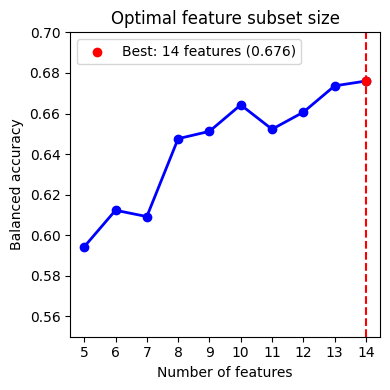


Optimal configuration:
  Number of features: 14
  Balanced accuracy:  0.676
  Features used:
    1. amplitude
    2. burst_rate
    3. autocorr_1cycle
    4. aperiodic_offset
    5. peak_frequency
    6. trough_voltage
    7. amplitude_slope
    8. response_latency
    9. rise_decay_symmetry
    10. period
    11. peak_snr
    12. peak_bandwidth
    13. aperiodic_slope
    14. peak_power

Confusion matrix for best model (14 features):
              Predicted
              Sham     tACS     tDCS    
Actual Sham   479      140      103     
       tACS   117      501      82      
       tDCS   121      109      425     


In [22]:
# test subsets of features to find the optimal set
results_df, best_n = test_feature_subsets(
    stim_trials, features, importances_df,
    search_results['fine_best_params']
)

### Goal 2.4: Validate model performance

**Analysis overview**: Permutation testing was conducted to verify that the trained model learned real relationships between features and stimulation conditions rather than individual differences. In each permutation, training set subject-condition mapping labels were randomly shuffled, a new model was trained on the shuffled labels, and performance was evaluated on the held-out test set with real labels. This process was repeated 100 times to construct a null distribution of performance scores expected under the hypothesis that features contain no information about stimulation condition. The real model's performance was compared against this null distribution to calculate a p-value.

**Key parameters**:
- Number of permutations: 100 (0.01 p-value precision)
- Model: Gradient boosting with optimized hyperparameters and selected features
- Null hypothesis: Features contain no information about stimulation condition
- Statistical test: Proportion of permuted scores >= real score

**Results**: Real model balanced accuracy: 0.676, permuted model mean: 0.633 +/- 0.017, p < 0.01. The real model outperformed all permuted models.

**Interpretation**: The permutation test confirms the model learned genuine patterns rather than spurious correlations. However, the permuted models achieving relatively high accuracy indicates that individual-specific neural signatures contribute substantially to classification performance, with condition-specific effects providing an additional but modest improvement. Baseline-relative features contain discriminative information about stimulation conditions despite high single-trial variability.

Features: 14
Train set: 4846 trials
Test set: 2077 trials

Training model with real labels...

Performance with real labels:
  Accuracy:          0.676
  Balanced accuracy: 0.676
  F1 (macro):        0.676

Processing permutation 1 of 100...
Processing permutation 11 of 100...
Processing permutation 21 of 100...
Processing permutation 31 of 100...
Processing permutation 41 of 100...
Processing permutation 51 of 100...
Processing permutation 61 of 100...
Processing permutation 71 of 100...
Processing permutation 81 of 100...
Processing permutation 91 of 100...

Permutation test results (balanced accuracy):
  Mean:   0.633
  SD:     0.017
  Min:    0.599
  Max:    0.669
  Median: 0.634

p-value: 0.0000


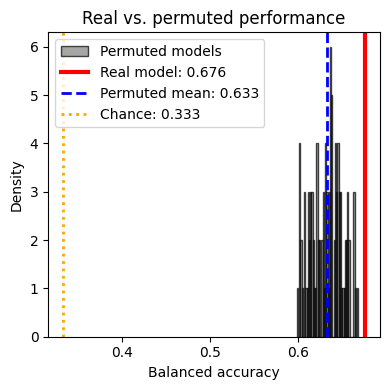

In [23]:
# set optimal features
optimal_features = importances_df.head(best_n)['feature'].tolist()

# run permutation tests
perm_results = permutation_test(
    stim_trials,
    optimal_features,
    search_results['fine_best_params']
)